In [1]:
import re
import numpy as np
from PIL import Image

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop

以下為使用到的資料集：

共用40個類別(40個人臉)：s1~s40

![jupyter](https://raw.githubusercontent.com/sudharsan13296/Hands-On-Meta-Learning-With-Python/7a73852d3439f11b84fd1b8d0c79be83e1ae0046/02.%20Face%20and%20Audio%20Recognition%20using%20Siamese%20Networks/Images/1.png)

每一個類別10張圖片

![jupyter](https://raw.githubusercontent.com/sudharsan13296/Hands-On-Meta-Learning-With-Python/7a73852d3439f11b84fd1b8d0c79be83e1ae0046/02.%20Face%20and%20Audio%20Recognition%20using%20Siamese%20Networks/Images/3.png)

自己加的展示網路預測結果的函數，包含：

測試輸入的圖片對、輸入圖片對的labels(是來自同類還是來自不同類)、網路的預測輸出(相似還是不相似)

In [35]:
def show_image(image_array,label, predictions,num):
    new_image=[]
    new_image.append(np.reshape(image_array[num,0,:,:,0],[56,46]))
    new_image.append(np.reshape(image_array[num,1,:,:,0],[56,46]))
    plt.subplot(1,2,1)
    plt.imshow(new_image[0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(new_image[1], cmap='gray')
    plt.title(["true:",label[num,0],"prediction:",predictions[num,0]])
    return plt.show()

讀取圖片的函數

In [3]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

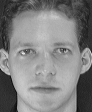

In [4]:
Image.open("data/orl_faces/s1/1.pgm")

In [5]:
img = read_image('data/orl_faces/s1/1.pgm')

觀察輸入圖片的大小，對後續輸入特徵的組成與圖片的重組很重要

In [6]:
img.shape

(112, 92)

size：將圖片縮小多少倍
；
total_sample_size：要生成多少訓練+測試圖片對

In [7]:
size = 2
total_sample_size = 10000

# 創建圖片對

這個函數中執行的事情為：

1.x_geuine_pair、x_imposite_pair，抓取真圖片對(兩圖片來自相同類，即同一人)與假圖片對(兩圖片來自不同類，即不同人)

2.y_genuine、y_imposite，給圖片對設置的labels(即若圖片對為真設為0，為假則設為1)

這裡原作者創建的圖片對為x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])，

x_geuine_pair第一個元素為總sample個數；第二個元素為有幾個圖片，這裡使用有兩張圖片組成；第三個元素為輸入圖片的色彩通道，因為為黑白圖片所以只有一個通道；第四與第五個元素為圖片的寬與高

但是真正訓練網路時會有錯誤，所以改成 x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1],dtype=('float32'))

後面介紹網路的時候會詳細介紹原因(主要是因為網路對於輸入的要求)

In [194]:
def get_data(size, total_sample_size):
    #read the image
    image = read_image('data/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1],dtype=('float32'))  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1],dtype=('float32'))
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0,  :, :,0] = img1
            x_geuine_pair[count, 1,  :, :,0] = img2
            
            #as we are drawing images from the same directory we assign label as 1(作者使用的，後面會解釋使用1/0的差別). (genuine pair)
            y_genuine[count] = 0
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1],dtype=('float32'))
    y_imposite = np.zeros([total_sample_size, 1],dtype=('float32'))
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(1,40)
                ind2 = np.random.randint(1,40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0,  :, :,0] = img1
            x_imposite_pair[count, 1,  :, :,0] = img2
            #as we are drawing images from the different directory we assign label as 0(作者使用的，後面會解釋使用1/0的差別). (imposite pair)
            y_imposite[count] = 1
            count += 1
            
            #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [195]:
X, Y = get_data(size, total_sample_size)

In [196]:
X.shape

(20000, 2, 56, 46, 1)

要輸入圖片對(sample)的array

第一個元素為總sample個數，因為是結合真圖片對與假圖片對，所以為2*10000

第二個元素代表真(假)圖片對裡有兩張圖片

第三第四元素代表圖片的長寬(已減小)

第五個元素為對應labels所設置

In [197]:
Y.shape

(20000, 1)

將全部的輸入圖片對(sample,20000個)，75%分給訓練(15000個)，25%分給測試(5000個)

In [198]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

# 建構基本網路

兩個active function為ReLU的卷積層與最大池化(MaxPooling)，然後是兩個平面層(flatten)

下面開始探討為甚麼最一開始設置圖片對時要更改原作者的程式：

1.這裡最一開始原作者使用border_mode='valid'，代表卷積過後尺寸會變小，相當於padding='valid'

2.第二個就是造成最大問題的，dim_ordering='th'

dim_ordering：可以為‘th’或‘tf’。'th'模式中通道維（如彩色圖像的3通道）位於第1個位置（維度從0開始算），而在'tf'模式中，通道維位於第3個位置。例如128*128的三通道彩色圖片，在'th'模式中input_shape應寫為（3，128，128），而在'tf'模式中應寫為（128，128，3），注意這裡3出現在第0個位置，因為input_shape不包含樣本數的維度，在其內部實現中，實際上是（None，3，128，128）和（None，128，128，3）。默認是image_dim_ordering指定的模式，可在~/.keras/keras.json中查看，若沒有設置過則為'tf'。

如果直接訓練的話，會顯示錯誤，一開始以為是使用keras版本的問題，因此將dim_ordering='th'改成data_format =  'channels_first'，

但是接下來就開始出現UnimplementedError: Graph execution error，

以為是因為padding讓圖片變小的關係，因此又把padding='valid'改成padding='same'，

結果就是辨識出來的準確率很差，只有0.74，與作者做出的0.92相差甚遠，

因此決定重頭來過，盡量不更改到原本網路架構設計的padding，但是就是無法訓練，會有UnimplementedError: Graph execution error的錯誤，

查了很久的資料，發現不能設定data_format =  'channels_first'，雖然建造模型沒問題，但在compile、predict的時候都會有問題，

所以還是得讓data_format =  'channels_last'，也就是將通道維放在最前面，因此才去更改最開始圖片對的創建，最後才成功得到高準確率。

In [13]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0],
                 (kernel_size, kernel_size),
                 input_shape=(56,46,1),
                 padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1],
                 (kernel_size, kernel_size),
                 padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [212]:
x_train.shape

(15000, 2, 56, 46, 1)

input_dim為x_train的第三個元素開始，也就是(56, 46, 1)

In [199]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

創建base_network，經由基本網路提取到的圖片對的特徵feat_vecs_a、feat_vecs_b

In [213]:
base_network = build_base_network(input_dim)
base_network.summary()
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 54, 44, 6)         60        
                                                                 
 activation_20 (Activation)  (None, 54, 44, 6)         0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 27, 22, 6)        0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 27, 22, 6)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 25, 20, 12)        660       
                                                                 
 activation_21 (Activation)  (None, 25, 20, 12)        0         
                                                     

# enegy function 使用L2 distance：

計算圖片對的特徵feat_vecs_a、feat_vecs_b之間的距離

In [16]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [17]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [201]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

其中模型的輸出為distance(輸入圖片對的特徵向量距離)

In [202]:
epochs = 13
rms = RMSprop()
model = Model(inputs=[img_a, img_b], outputs=distance)

# Loss function 使用contrastive_loss

公式#1：

![jupyter](https://i.stack.imgur.com/zDtA0.png)

來自同類別的圖片(相似)設為1，來自不同類別(不相似)的圖片設為0，

這裡使用![jupyter](https://pic3.zhimg.com/80/v2-bfa48776c69d7e2cbfcf9bc118e5e86e_720w.webp)公式#2：

但是最初在給圖片對做label的時候，要將來自同類別的圖片(相似)設為0，來自不同類別的圖片設為1，

原作者使用的是#1公式，這裡使用#2公式。

In [204]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    #return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))#1
    return K.mean((1-y_true) * K.square(y_pred) + (y_true) * K.square(K.maximum(margin - y_pred, 0)))#2

優化器使用rms

In [205]:
model.compile(loss=contrastive_loss, optimizer=rms)

進行模型訓練

In [206]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1]

model.fit([img_1, img_2], y_train, validation_split=.25,
          batch_size=128, verbose=2, epochs=epochs)

Epoch 1/13
88/88 - 3s - loss: 0.2326 - val_loss: 0.2822 - 3s/epoch - 29ms/step
Epoch 2/13
88/88 - 2s - loss: 0.1657 - val_loss: 0.2735 - 2s/epoch - 17ms/step
Epoch 3/13
88/88 - 2s - loss: 0.1327 - val_loss: 0.2004 - 2s/epoch - 17ms/step
Epoch 4/13
88/88 - 2s - loss: 0.0994 - val_loss: 0.1274 - 2s/epoch - 17ms/step
Epoch 5/13
88/88 - 2s - loss: 0.0774 - val_loss: 0.0818 - 2s/epoch - 17ms/step
Epoch 6/13
88/88 - 2s - loss: 0.0636 - val_loss: 0.0735 - 2s/epoch - 18ms/step
Epoch 7/13
88/88 - 2s - loss: 0.0527 - val_loss: 0.0538 - 2s/epoch - 17ms/step
Epoch 8/13
88/88 - 2s - loss: 0.0458 - val_loss: 0.0430 - 2s/epoch - 17ms/step
Epoch 9/13
88/88 - 2s - loss: 0.0407 - val_loss: 0.0312 - 2s/epoch - 17ms/step
Epoch 10/13
88/88 - 1s - loss: 0.0359 - val_loss: 0.0372 - 1s/epoch - 17ms/step
Epoch 11/13
88/88 - 1s - loss: 0.0330 - val_loss: 0.0265 - 1s/epoch - 17ms/step
Epoch 12/13
88/88 - 2s - loss: 0.0300 - val_loss: 0.0279 - 2s/epoch - 18ms/step
Epoch 13/13
88/88 - 2s - loss: 0.0275 - val_loss:

pred為模型的輸出，為測試圖片對的特徵向量距離

In [207]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

plot其中一個測試圖片對的真實label與預測結果

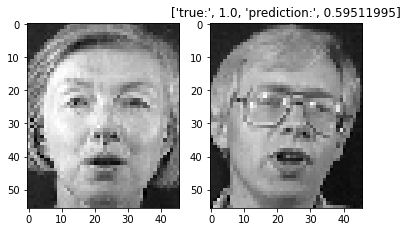

In [208]:
show_image(x_test,y_test,pred,0)

# 關於圖片的標題

true：代表實際輸入的圖片對的label，如果true=0代表輸入圖片對來自相同類別；true=1代表輸入圖片對來自不同類別。

Prediction：代表預測輸入圖片對的特徵向量間的距離(相似度)，當值越大，代表距離越遠，輸入的圖片對越不同；值越小，代表距離越近，輸入的圖片對越相同

所以當true=1，而Prediction越大，代表預測的越準確；或是true=0，而Prediction越小，也是模型預測準確率高的表現。

In [191]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.4].mean()

contrastive_loss使用#1 的公式 使用到的compute_accuracy

因為來自同類別的圖片(相似)設為1，來自不同類別(不相似)的圖片設為0，

輸出(pred)為輸入圖片對的特徵向量距離，

1)predictions.ravel()

![jupyter](1.jpg)

2)predictions.ravel() < 0.5 條件判斷，輸出boolean矩陣

![jupyter](2.jpg)

3)labels[predictions.ravel() < 0.5]：使用boolean矩陣作為索引，當索引為True，返回labels對應索引處的元素，即返回神經網路認為(預測)為同類別的圖片: 

![jupyter](3.jpg)

4)有可能predictions認為是True(特徵距離小，來自同類圖片)，但實際上labels為0(來自不同類圖片)，因為這裡設定來自同類別的圖片為1，因此可以直接加總labels[predictions.ravel() < 0.5]的值並做mean來得到準確值

In [192]:
print(compute_accuracy(pred, y_test))

0.98273027


但若contrastive_loss使用 #2 公式

則來自同類別的圖片(相似)設為0，來自不同類別的圖片設為1，

而predictions認為是True(特徵距離小，來自同類圖片)，如果預測正確的話，labels為0，所以加總labels[predictions.ravel() < 0.5]的值越小代表預測的越準確，

因此加總labels[predictions.ravel() < 0.5]，實際上是在計算"1"的個數，也就是在計算預測的錯誤率。

因此這裡如果要算預測準確率的話，使用1-compute_accuracy(pred, y_test)(錯誤率) 來得到

In [209]:
print(1-compute_accuracy(pred, y_test))

0.9645579271018505
